In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
GITHUB_CDN = "https://raw.githubusercontent.com/realamirhe/github-stargazer"

tens = range(1, 10)

js_repo_urls = map(lambda idx: f"{GITHUB_CDN}/master/data/js-{idx}.csv", tens)
py_repo_urls = map(lambda idx: f"{GITHUB_CDN}/master/data/py-{idx}.csv", tens)
first_chunk_url =  f"{GITHUB_CDN}/master/data/datas.csv"
second_chunk_url =  f"{GITHUB_CDN}/master/data/datas-2.csv"

data_urls = [*js_repo_urls, *py_repo_urls, first_chunk_url, second_chunk_url]

In [3]:
datas = pd.concat(list(map(pd.read_csv, data_urls)))
datas = datas.select_dtypes(exclude=['object'])
datas = datas.reset_index()
datas = datas.drop_duplicates()
datas = datas.drop(columns=['index', 'Unnamed: 0', 'score'], axis=1)
datas = datas.replace({ False: 0, True: 1 })
datas.head()

,private,owner.public_repos,owner.public_gists,owner.followers,owner.following,fork,forks,size,stargazers_count,watchers_count,...,has_pages,has_discussions,forks_count,archived,disabled,open_issues_count,allow_forking,is_template,web_commit_signoff_required,watchers
0,0,64,62,23302,11,0,540,7954,1962,1962,...,0,0,540,0,0,30,1,0,0,1962
1,0,274,758,10063,11,0,61,3462,435,435,...,0,0,61,0,0,13,1,0,0,435
2,0,50,0,11,0,0,605,168196,3031,3031,...,0,0,605,0,0,15,1,0,0,3031
3,0,64,62,23302,11,0,516,2639,2200,2200,...,1,0,516,0,0,247,1,0,0,2200
4,0,58,50,195,16,0,7,192,68,68,...,0,0,7,0,0,1,1,0,0,68


In [4]:
import seaborn as sns

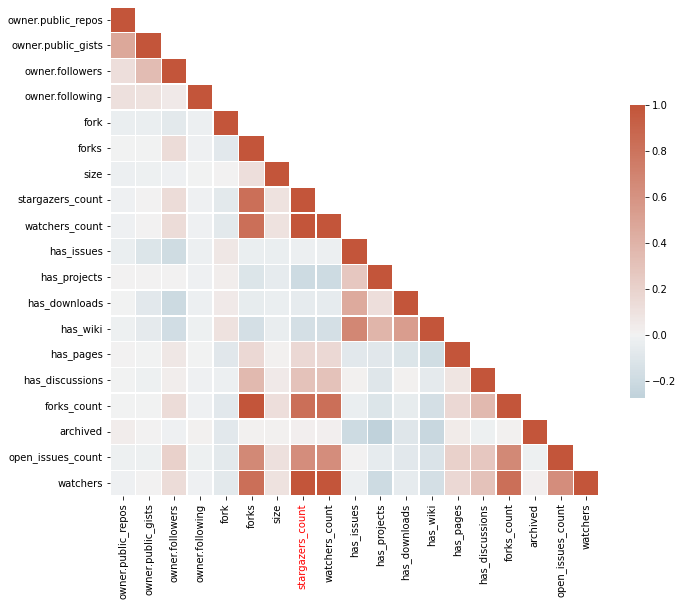

In [5]:
keep = [c for c in list(datas) if len(datas[c].unique()) > 1]
corr = datas[keep].corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax1 = sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .6})

for tick_label in ax1.xaxis.get_ticklabels():
  tick_label.set_color('red' if tick_label.get_text() == 'stargazers_count' else 'black')

In [8]:
startruck_ranges = (-np.inf,2.5,np.inf)
startruck_labels = [0, 1]

y = datas['stargazers_count']
y = np.log(y + 0.001)
y = pd.cut(y, [i-1 for i in startruck_ranges], labels=startruck_labels)
y = y.astype(np.float64)

# remove high correlated datas
X = datas.drop(columns=['stargazers_count', 'watchers', 'watchers_count'])

## PCA

In [10]:
from sklearn.decomposition import PCA

In [18]:
n_components = 2
pca = PCA(n_components)
pca.fit(X)

print(f"Only {n_components} component can cover {np.sum(pca.explained_variance_ratio_)*100:.3f}% of data")

Only 2 component can cover 99.984% of data


In [ ]:
X_pca_transformed = pca.transform(X)
x_train, x_test, y_train, y_test = train_test_split(
    X_pca_transformed, 
    y, 
    test_size=0.2, 
    random_state=42
)

## TSNE

In [34]:
from time import time
from sklearn import manifold
from matplotlib.ticker import NullFormatter

In [45]:
# https://github.com/community/community/discussions/20560
startruck_ranges = (0, 1, 16, 128, 512, 4096, 16384, 65536, 262144)
startruck_labels = [0, 1, 2, 3, 4, 5, 6, 7]

y_cutted = pd.cut(y, [i-1 for i in startruck_ranges], labels=startruck_labels)
startruck_missing_value = len(startruck_labels) + 1
y_cutted = y_cutted.cat.add_categories(startruck_missing_value).fillna(startruck_missing_value)

t-SNE: 3.9e-05 sec


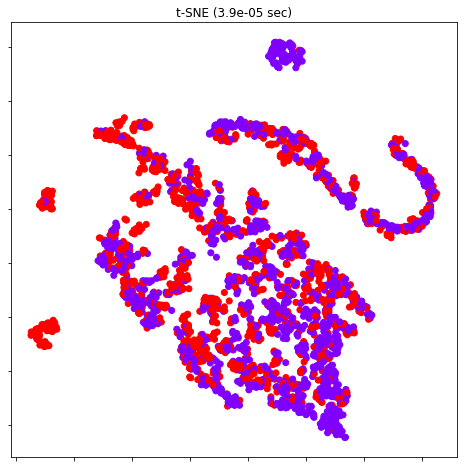

In [57]:
t0 = time()
tsne = manifold.TSNE(n_components=2, random_state=0)
trans_data = tsne.fit_transform(X).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)
jitter = np.random.random(trans_data.shape) * 2
plt.scatter(
    trans_data[0] + jitter[0, :], 
    trans_data[1] + jitter[1, :], 
    c=y_cutted,
    cmap=plt.cm.rainbow
)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
plt.axis("tight")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.show()

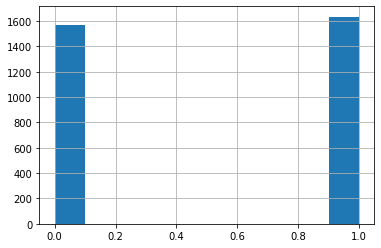

In [58]:
y.hist()

In [121]:
def cut_y(y):
  # https://github.com/community/community/discussions/20560
  startruck_ranges = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,32,64,128,512,1024,2048,4096)
  startruck_labels = list(range(len(startruck_ranges) -1))
  y_cutted = pd.cut(y, [i-1 for i in startruck_ranges], labels=startruck_labels)
  startruck_missing_value = len(startruck_labels) + 1
  y_cutted = y_cutted.astype(np.float64)
  y_cutted[np.isnan(y_cutted)] = startruck_missing_value
  return y_cutted.astype(np.int8)
  

y = datas['stargazers_count']
y_cutted = cut_y(y)

0       1962
1        435
2       3031
3       2200
4         68
        ... 
4827      32
4828       3
4829     310
4830       1
4831       2
Name: stargazers_count, Length: 3203, dtype: int64

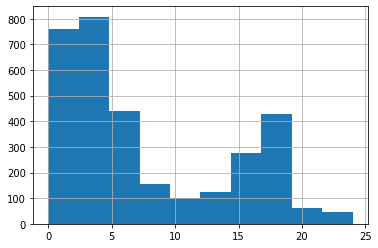

In [86]:
y_cutted.hist()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE: 22 sec


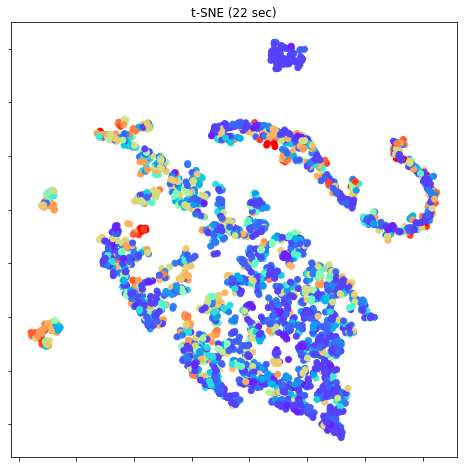

In [87]:
t0 = time()
tsne = manifold.TSNE(n_components=2, random_state=0)
trans_data = tsne.fit_transform(X).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)
jitter = np.random.random(trans_data.shape) * 2
plt.scatter(
    trans_data[0] + jitter[0, :], 
    trans_data[1] + jitter[1, :], 
    c=y_cutted,
    cmap=plt.cm.rainbow
)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
plt.axis("tight")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.show()

## KNN

In [93]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

Text(0.5, 1.0, '5-fold cross validation for KNN')

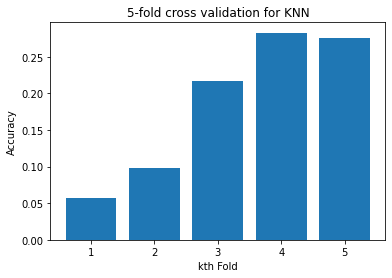

In [123]:
# k-fold
kf = KFold(n_splits=5)
# model
knn = KNeighborsClassifier(n_neighbors=4)
# bechmark
acc = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    clf = knn.fit(X.iloc[train_index], y.iloc[train_index])
    y_pred = clf.predict(X.iloc[test_index])
    y_pred = cut_y(y_pred)
    y_true = y.iloc[test_index]
    acc.append(accuracy_score(y_true, y_pred))

plt.bar(np.arange(5)+1,acc)
plt.xlabel('kth Fold')
plt.ylabel('Accuracy')
plt.title('5-fold cross validation for KNN')